**Wprowadzenie i wczytanie danych, import niezbędnych bibliotek**

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import StandardScaler

# 1. Wczytanie danych
df = sns.load_dataset('titanic')

# Podgląd danych
print("Rozmiar danych:", df.shape)
display(df.head())

Rozmiar danych: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


**Eksploracja danych - analiza braków danych, statystyki oraz zależności między zmiennymi**

--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None

--- DESCRIBE ---
         survived      pclass         age  

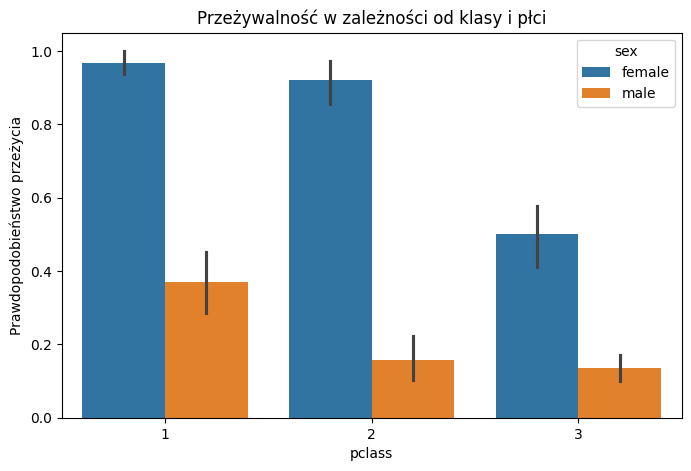

In [5]:
# 1.1 Podstawowe statystyki
print("--- INFO ---")
print(df.info())
print("\n--- DESCRIBE ---")
print(df.describe())

# 1.2 Braki danych
print("\n--- BRAKI DANYCH ---")
print(df.isnull().sum())

# 1.3 Proporcja osób, które przeżyły
print("\n--- PRZEŻYWALNOŚĆ ---")
print(f"Ogólna przeżywalność: {df['survived'].mean():.2%}")
print("\nWg Płci:")
print(df.groupby('sex')['survived'].mean())
print("\nWg Klasy:")
print(df.groupby('pclass')['survived'].mean())

# 1.4 Wykres przeżywalności
plt.figure(figsize=(8, 5))
sns.barplot(x='pclass', y='survived', hue='sex', data=df)
plt.title('Przeżywalność w zależności od klasy i płci')
plt.ylabel('Prawdopodobieństwo przeżycia')
plt.show()

**Przygotowanie danych - czyszczenie. uzupełnianie braków, kodowanie zmiennych i podział na zbiór treningowy/testowy**

In [6]:
# 2.1 Usuwanie zbędnych kolumn
# Usuwamy 'deck' (dużo braków), oraz kolumny dublujące informacje lub tekstowe
cols_to_drop = ['deck', 'embark_town', 'alive', 'who', 'adult_male', 'class']
df_clean = df.drop(columns=cols_to_drop)

# 2.2 Uzupełnianie braków w 'age' medianą
median_age = df_clean['age'].median()
df_clean['age'] = df_clean['age'].fillna(median_age)

# Uzupełniamy też 'embarked' najczęstszą wartością (modą), aby nie tracić wierszy
df_clean['embarked'] = df_clean['embarked'].fillna(df_clean['embarked'].mode()[0])

# 2.3 One-Hot Encoding (zamiana kategorycznych na liczby)
# drop_first=True usuwa jedną kolumnę, aby uniknąć współliniowości (np. usuwa 'sex_female', zostawia 'sex_male')
df_model = pd.get_dummies(df_clean, columns=['sex', 'embarked'], drop_first=True)

# Sprawdzenie gotowych danych
print("Kolumny po przetworzeniu:", df_model.columns.tolist())

# 2.4 Podział na zbiór treningowy i testowy (80/20, stratify)
X = df_model.drop('survived', axis=1)
y = df_model['survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Zbiór treningowy: {X_train.shape}")
print(f"Zbiór testowy: {X_test.shape}")

Kolumny po przetworzeniu: ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'alone', 'sex_male', 'embarked_Q', 'embarked_S']
Zbiór treningowy: (712, 9)
Zbiór testowy: (179, 9)


**Budowa modelu i interpretacja - trening regresji logistycznej, analiza wag (współczynniki) oraz Odds Ratio**

In [7]:
# 3.1 Trening modelu
# Używamy solvera 'liblinear' (dobry dla mniejszych zbiorów) i zwiększamy max_iter dla pewności zbieżności
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# 3.2 Współczynniki modelu
coef_df = pd.DataFrame({
    'Cecha': X_train.columns,
    'Współczynnik': model.coef_[0]
})
# Sortujemy po wartości bezwzględnej, by znaleźć najważniejsze
coef_df['Abs_Współczynnik'] = coef_df['Współczynnik'].abs()
print("\n--- WSPÓŁCZYNNIKI ---")
print(coef_df.sort_values(by='Abs_Współczynnik', ascending=False).head(3))

# 3.3 Odds Ratio (Iloraz szans)
coef_df['Odds_Ratio'] = np.exp(coef_df['Współczynnik'])
print("\n--- ODDS RATIO (Iloraz Szans) ---")
print(coef_df[['Cecha', 'Odds_Ratio']].sort_values(by='Odds_Ratio', ascending=False))

# Interpretacja dla 'sex_male'
or_male = coef_df.loc[coef_df['Cecha'] == 'sex_male', 'Odds_Ratio'].values[0]
print(f"\nINTERPRETACJA sex_male: Odds Ratio wynosi {or_male:.4f}.")
print("Oznacza to, że bycie mężczyzną zmniejsza szanse na przeżycie wielokrotnie w porównaniu do bycia kobietą (przy ustalonych innych zmiennych).")


--- WSPÓŁCZYNNIKI ---
      Cecha  Współczynnik  Abs_Współczynnik
6  sex_male     -2.339508          2.339508
0    pclass     -0.777610          0.777610
5     alone     -0.440911          0.440911

--- ODDS RATIO (Iloraz Szans) ---
        Cecha  Odds_Ratio
7  embarked_Q    1.483989
4        fare    1.005264
1         age    0.974638
3       parch    0.849859
8  embarked_S    0.841577
2       sibsp    0.719787
5       alone    0.643450
0      pclass    0.459503
6    sex_male    0.096375

INTERPRETACJA sex_male: Odds Ratio wynosi 0.0964.
Oznacza to, że bycie mężczyzną zmniejsza szanse na przeżycie wielokrotnie w porównaniu do bycia kobietą (przy ustalonych innych zmiennych).


**Ewaluacja modelu - sprawdzanie jakości modelu na zbiorze testowym**

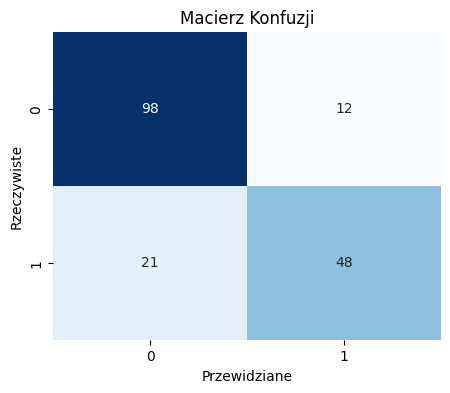

--- METRYKI ---
Accuracy:    0.8156
Precision:   0.8000
Recall:      0.6957
F1-score:    0.7442
Specificity: 0.8909


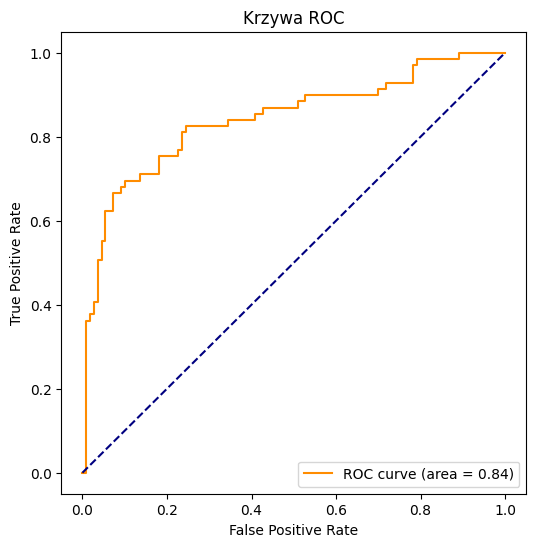


KTÓRA METRYKA NAJWAŻNIEJSZA?
W przypadku katastrof zazwyczaj kluczowy jest Recall (Czułość).
Chcemy znaleźć jak najwięcej osób, które przeżyły (minimalizować False Negatives), nawet kosztem fałszywych alarmów.


In [8]:
# 4.1 Predykcja
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 4.2 Macierz konfuzji
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Macierz Konfuzji')
plt.xlabel('Przewidziane')
plt.ylabel('Rzeczywiste')
plt.show()

# 4.3 Metryki
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print("--- METRYKI ---")
print(f"Accuracy:    {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:   {precision_score(y_test, y_pred):.4f}")
print(f"Recall:      {recall_score(y_test, y_pred):.4f}")
print(f"F1-score:    {f1_score(y_test, y_pred):.4f}")
print(f"Specificity: {specificity:.4f}")

# 4.4 Krzywa ROC i AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

# 4.5 Odpowiedź na pytanie
print("\nKTÓRA METRYKA NAJWAŻNIEJSZA?")
print("W przypadku katastrof zazwyczaj kluczowy jest Recall (Czułość).")
print("Chcemy znaleźć jak najwięcej osób, które przeżyły (minimalizować False Negatives), nawet kosztem fałszywych alarmów.")

**Eksperymenty - badanie wpływu progu odcięcia oraz zbalansowania wag klas**

In [9]:
# 5.1 Różne progi klasyfikacji
thresholds_list = [0.3, 0.4, 0.5, 0.6, 0.7]
print("\n--- WYNIKI DLA RÓŻNYCH PROGÓW ---")
print(f"{'Próg':<10} {'Precision':<10} {'Recall':<10}")

for t in thresholds_list:
    preds_t = (y_prob >= t).astype(int)
    p = precision_score(y_test, preds_t)
    r = recall_score(y_test, preds_t)
    print(f"{t:<10} {p:<10.4f} {r:<10.4f}")

# 5.2 Model z class_weight='balanced'
model_bal = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
model_bal.fit(X_train, y_train)
y_pred_bal = model_bal.predict(X_test)

print("\n--- MODEL ZBALANSOWANY ---")
print(f"Precision: {precision_score(y_test, y_pred_bal):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_bal):.4f}")
print("(Porównaj z modelem bazowym: zazwyczaj Recall rośnie, a Precision spada)")


--- WYNIKI DLA RÓŻNYCH PROGÓW ---
Próg       Precision  Recall    
0.3        0.6747     0.8116    
0.4        0.7101     0.7101    
0.5        0.8000     0.6957    
0.6        0.8723     0.5942    
0.7        0.8857     0.4493    

--- MODEL ZBALANSOWANY ---
Precision: 0.7000
Recall:    0.7101
(Porównaj z modelem bazowym: zazwyczaj Recall rośnie, a Precision spada)


**Standaryzacja i regularyzacja - standaryzacja zmiennych numerycznych i badanie wpływu parametrów L1/L2**


--- WYNIKI DLA RÓŻNYCH WARTOŚCI C ---
         C       AUC  Sum_Beta
0    0.001  0.773913  0.414055
1    0.010  0.824506  1.458122
2    0.100  0.834914  3.550805
3    1.000  0.846772  5.536557
4   10.000  0.850329  6.192512
5  100.000  0.850593  6.280333


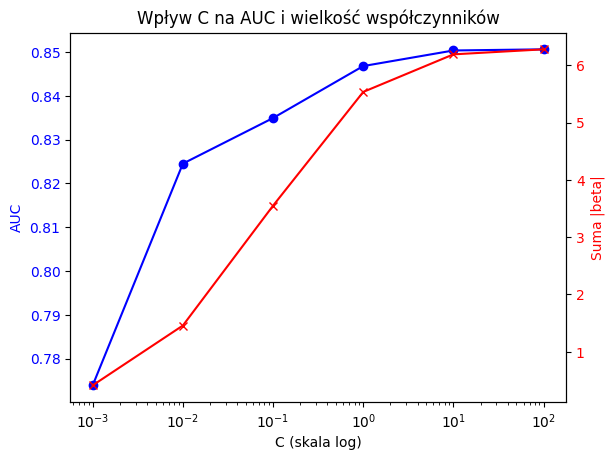


--- PORÓWNANIE L1 (Lasso) vs L2 (Ridge) dla C=0.1 ---
        Cecha  L2_Coeff  L1_Coeff
0      pclass -0.340206 -0.419403
1         age -0.296015 -0.217666
2       sibsp -0.291128 -0.159845
3       parch -0.071572  0.000000
4        fare  0.438919  0.286470
5       alone -0.229438  0.000000
6    sex_male -1.619571 -1.924213
7  embarked_Q  0.248552  0.000000
8  embarked_S -0.015404  0.000000

Wniosek: Regularyzacja L1 (Lasso) potrafi wyzerować wagi mało istotnych cech (feature selection).


In [10]:
# 6.1 Standaryzacja (tylko zmienne numeryczne)
# Musimy uważać, by nie standaryzować zmiennych 0/1 (one-hot), choć w regresji logistycznej często standaryzuje się wszystko.
# Tutaj dla precyzji wystandaryzujemy główne numeryczne: age, sibsp, parch, fare.
num_cols = ['age', 'sibsp', 'parch', 'fare']

scaler = StandardScaler()

# Kopia danych, by nie psuć poprzednich
X_train_std = X_train.copy()
X_test_std = X_test.copy()

# Fit tylko na Train!
X_train_std[num_cols] = scaler.fit_transform(X_train_std[num_cols])
X_test_std[num_cols] = scaler.transform(X_test_std[num_cols])

# 6.2 Wpływ parametru C (Regularyzacja L2)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
results_c = []

for c_val in C_values:
    # L2 to domyślna regularyzacja (penalty='l2')
    m = LogisticRegression(C=c_val, penalty='l2', solver='liblinear', random_state=42)
    m.fit(X_train_std, y_train)

    # AUC na teście
    probs = m.predict_proba(X_test_std)[:, 1]
    auc_val = roc_auc_score(y_test, probs)

    # Suma modułów współczynników
    sum_beta = np.sum(np.abs(m.coef_))

    results_c.append({'C': c_val, 'AUC': auc_val, 'Sum_Beta': sum_beta})

df_res = pd.DataFrame(results_c)
print("\n--- WYNIKI DLA RÓŻNYCH WARTOŚCI C ---")
print(df_res)

# Wykres zależności
fig, ax1 = plt.subplots()

ax1.set_xlabel('C (skala log)')
ax1.set_ylabel('AUC', color='blue')
ax1.plot(df_res['C'], df_res['AUC'], color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xscale('log')

ax2 = ax1.twinx()
ax2.set_ylabel('Suma |beta|', color='red')
ax2.plot(df_res['C'], df_res['Sum_Beta'], color='red', marker='x')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Wpływ C na AUC i wielkość współczynników')
plt.show()

# 6.3 Porównanie L1 vs L2 (C=0.1)
print("\n--- PORÓWNANIE L1 (Lasso) vs L2 (Ridge) dla C=0.1 ---")
# L2
model_l2 = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', random_state=42)
model_l2.fit(X_train_std, y_train)

# L1
model_l1 = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=42)
model_l1.fit(X_train_std, y_train)

# Porównanie wag
coeffs_comp = pd.DataFrame({
    'Cecha': X_train.columns,
    'L2_Coeff': model_l2.coef_[0],
    'L1_Coeff': model_l1.coef_[0]
})
print(coeffs_comp)
print("\nWniosek: Regularyzacja L1 (Lasso) potrafi wyzerować wagi mało istotnych cech (feature selection).")